In [93]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
import sys
sys.path.append("../../sample")
from radial_density import RadialDensity

plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,bm}')
matplotlib.rcParams.update({'font.size': 16})

# matplotlib.use('TkAgg')

In [94]:
infile = "data_test_boozer.pickle"
indata = pickle.load(open(infile,'rb'))
n_particles = indata['n_particles']
tmax = indata['tmax']
c_times = indata['c_times']
mu_crit =indata['mu_crit']
modB = indata['modB']
stz_inits = indata['stz_inits'] 
vpar_inits = indata['vpar_inits']
s_pdf = indata['s_pdf']
s_mean = indata['s_mean']
s_std = indata['s_std']
mu = indata['mu']
mu_mean = indata['mu_mean']
mu_std = indata['mu_std']
# strata
prob_mu_strata1 = indata['prob_mu_strata1']
prob_mu_strata2 = indata['prob_mu_strata2']


In [95]:
e_ub = 3.5
e_lb = 3.5*np.exp(-2)
energy_func = lambda t:  (3.5*np.exp(-2*t/tmax) - e_lb)/(e_ub-e_lb)
energy = energy_func(c_times)

In [96]:
sampler = RadialDensity(1000)

# Correlations between input and outputs

Text(0.5, 0, 's')

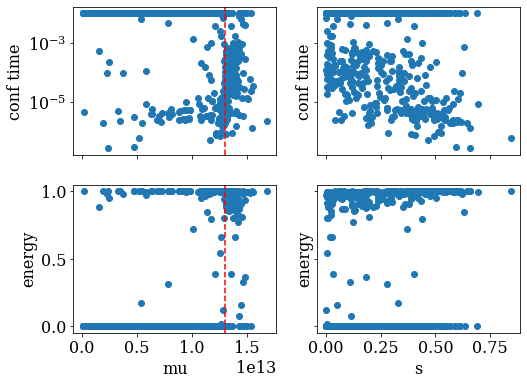

In [97]:
fig,((ax1,ax3),(ax2,ax4)) = plt.subplots(figsize=(8,6), nrows=2,ncols=2,sharex="col",sharey="row")

# plot against mu
ax1.scatter(mu, c_times)
ax1.set_ylabel("conf time")
ax2.scatter(mu, energy)
ax2.set_ylabel("energy")
ax2.set_xlabel("mu")
ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.axvline(x=mu_crit,linestyle='--',color='r')
ax2.axvline(x=mu_crit,linestyle='--',color='r')

# plot stuff against s
s = stz_inits[:,0]
ax3.scatter(s, c_times)
ax3.set_ylabel("conf time")
ax4.scatter(s, energy)
ax4.set_ylabel("energy")
ax4.set_xlabel("s")

# 1. Control Variate for confinement time

In [98]:
def control_variate(x,y,y_mean,y_std):
    rho = np.corrcoef(y,x)[0,1]
    c = -rho* np.std(x)/y_std
    cv = x + c*(y-y_mean)
    return cv

## 1.1 Control variate using s

In [99]:
s = stz_inits[:,0]
cv = control_variate(c_times,s,s_mean,s_std)
print('MC mean',np.mean(c_times))
print('MC std',np.std(c_times))
print('CV mean',np.mean(cv))
print('CV std',np.std(cv))
print("Reduction in standard deviation",1-np.std(cv)/np.std(c_times))
alpha = np.std(cv)/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

MC mean 0.0071478412399875605
MC std 0.00445097255730962
CV mean 0.0071436905307467515
CV std 0.004273539123310581
Reduction in standard deviation 0.0398639694391395
Effective increase in number of samples 1.0847620043643929


## 1.2 Control variate using mu

In [100]:
cv = control_variate(c_times,mu,mu_mean,mu_std)
print('MC mean',np.mean(c_times))
print('MC std',np.std(c_times))
print('CV mean',np.mean(cv))
print('CV std',np.std(cv))
print("Reduction in standard deviation",1-np.std(cv)/np.std(c_times))
alpha = np.std(cv)/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

MC mean 0.0071478412399875605
MC std 0.00445097255730962
CV mean 0.007124339416496788
CV std 0.003866695621950639
Reduction in standard deviation 0.1312694984828543
Effective increase in number of samples 1.325042657558387


## 1.3 Control Variate using s and mu

In [101]:
"""
Use both s and mu as control variates. In this formulation we take a shortcut to building the control variate. 
We first find the optimal estimator when mu is a control variate,
    cv1 = Y + c1*(mu - mean(mu))
    c1 = -corr(mu,y)*np.std(c_times)/std(mu)
Then, with c1 fixed, we use S as a control variate with cv1. i.e. we use the control variate
    cv2 = cv1 + c2*(s - mean(s))
    c2 = -corr(s,cv1)*np.std(cv1)/std(s)
"""
cv1 = control_variate(c_times,mu,mu_mean,mu_std)
cv = control_variate(cv1,s,s_mean,s_std)
print('MC mean',np.mean(c_times))
print('MC std',np.std(c_times))
print('CV mean',np.mean(cv))
print('CV std',np.std(cv))
print("Reduction in standard deviation",1-np.std(cv)/np.std(c_times))
alpha = np.std(cv)/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

MC mean 0.0071478412399875605
MC std 0.00445097255730962
CV mean 0.007120117762919516
CV std 0.0036537576411262503
Reduction in standard deviation 0.17911027442174232
Effective increase in number of samples 1.4839879006386063


In [102]:
"""
Use both s and mu as control variates. This is the proper way to construct the control variate.

If Y is the confinement times and X = (mu,s) then we form the control variate
    cv = Y + (X - X_mean) @ c
where c satisfies
    Cov(X,X) @ c = - Cov(Y,X)
Since we know the standard deviations of mu and s, we can input those directly into this equation and simplify a bit. 
Then this equation only relies on correlation coefficients which are scale free. This helps avoid the error that arises
in estimation of coefficients. In short, we find c via the linear system A @ c = - b where
A = [[mu_std, s_std*corr(mu,s)] 
    [mu_std*corr(mu,s), s_std]]
b = y_std *[corr(mu,y),corr(s,y)]
"""
Sigma = np.array([[mu_std,s_std*np.corrcoef(s,mu)[0,1]],[mu_std*np.corrcoef(s,mu)[0,1],s_std]])
rho_s_c = np.corrcoef(s,c_times)[0,1]
rho_mu_c = np.corrcoef(mu,c_times)[0,1]
rhs = np.std(c_times)*np.array([rho_mu_c,rho_s_c])
c = -np.linalg.solve(Sigma,rhs)
X = np.vstack((mu,s)).T
X_mean = np.array([mu_mean,s_mean])
cv = c_times + (X-X_mean) @ c
print('MC mean',np.mean(c_times))
print('MC std',np.std(c_times))
print('CV mean',np.mean(cv))
print('CV std',np.std(cv))
print("Reduction in standard deviation",1-np.std(cv)/np.std(c_times))
alpha = np.std(cv)/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

MC mean 0.0071478412399875605
MC std 0.00445097255730962
CV mean 0.0071199876053465744
CV std 0.003653752862755702
Reduction in standard deviation 0.17911134797824857
Effective increase in number of samples 1.483991782153849


# 2. Control Variate for Energy retention

## 2.1 Control Variate using s

In [103]:
s = stz_inits[:,0]
cv = control_variate(energy,s,s_mean,s_std)
print('MC mean',np.mean(energy))
print('MC std',np.std(energy))
print('CV mean',np.mean(cv))
print('CV std',np.std(cv))
print("Reduction in standard deviation",1-np.std(cv)/np.std(energy))
alpha = np.std(cv)/np.std(energy)
print("Effective increase in number of samples",1/alpha**2)

MC mean 0.27871425649051335
MC std 0.43819537617040394
CV mean 0.2791342265234813
CV std 0.4197230072628714
Reduction in standard deviation 0.04215555414794947
Effective increase in number of samples 1.0899586678189568


## 2.2 Control variate using mu

In [104]:
cv = control_variate(energy,mu,mu_mean,mu_std)
print('MC mean',np.mean(energy))
print('MC std',np.std(energy))
print('CV mean',np.mean(cv))
print('CV std',np.std(cv))
print("Reduction in standard deviation",1-np.std(cv)/np.std(energy))
alpha = np.std(cv)/np.std(energy)
print("Effective increase in number of samples",1/alpha**2)

MC mean 0.27871425649051335
MC std 0.43819537617040394
CV mean 0.2810036587757978
CV std 0.38196615866205014
Reduction in standard deviation 0.12831996996355244
Effective increase in number of samples 1.3160906597080748


## 2.3 Control variate using s and mu

In [105]:
"""
Use both s and mu as control variates. In this formulation we take a shortcut to building the control variate. 
We first find the optimal estimator when mu is a control variate,
    cv1 = Y + c1*(mu - mean(mu))
    c1 = -corr(mu,y)*np.std(c_times)/std(mu)
Then, with c1 fixed, we use S as a control variate with cv1. i.e. we use the control variate
    cv2 = cv1 + c2*(s - mean(s))
    c2 = -corr(s,cv1)*np.std(cv1)/std(s)
"""
cv1 = control_variate(energy,mu,mu_mean,mu_std)
cv = control_variate(cv1,s,s_mean,s_std)
print('MC mean',np.mean(energy))
print('MC std',np.std(energy))
print('CV mean',np.mean(cv))
print('CV std',np.std(cv))
print("Reduction in standard deviation",1-np.std(cv)/np.std(energy))
alpha = np.std(cv)/np.std(energy)
print("Effective increase in number of samples",1/alpha**2)

MC mean 0.27871425649051335
MC std 0.43819537617040394
CV mean 0.2814305397672318
CV std 0.3598951136981317
Reduction in standard deviation 0.17868801619171604
Effective increase in number of samples 1.482462377977008


# Stratified Sampling

## Stratified Sampling over mu

In [106]:
c_times_strata1 = c_times[mu<mu_crit]
c_times_strata2 = c_times[mu>=mu_crit]
print("Reduction in standard deviation in strata1",1-np.std(c_times_strata1)/np.std(c_times))
print("Reduction in standard deviation in strata2",1-np.std(c_times_strata2)/np.std(c_times))

Reduction in standard deviation in strata1 0.23879668923614417
Reduction in standard deviation in strata2 0.23799468004399804


In [107]:
ss_mean = prob_mu_strata1*np.mean(c_times_strata1) + prob_mu_strata2*np.mean(c_times_strata2)
# single sample std
ss_std = np.sqrt((prob_mu_strata1*np.std(c_times_strata1))**2 + (prob_mu_strata2*np.std(c_times_strata2))**2)
print("SS mean",ss_mean)
print("SS std",ss_std)
print("Reduction in standard deviation",1-ss_std/np.std(c_times))
alpha = ss_std/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

SS mean 0.007149253254013617
SS std 0.0027654267246290045
Reduction in standard deviation 0.37869158054289154
Effective increase in number of samples 2.5905114863675243


## Stratified Sampling over s

In [119]:
s = stz_inits[:,0]
# strata boundary at 
s_boundary = s_mean
c_times_strata1 = c_times[s<s_boundary]
c_times_strata2 = c_times[s>=s_boundary]
prob_strata1 = sampler._cdf(s_boundary)
prob_strata2 = 1- prob_strata1
print("Reduction in standard deviation in strata1",1-np.std(c_times_strata1)/np.std(c_times))
print("Reduction in standard deviation in strata2",1-np.std(c_times_strata2)/np.std(c_times))

Reduction in standard deviation in strata1 0.10461137568829093
Reduction in standard deviation in strata2 -0.08917924758309148


In [120]:
print(np.std(c_times_strata1),np.std(c_times_strata2),np.std(c_times))

ss_mean = prob_strata1*np.mean(c_times_strata1) + prob_strata2*np.mean(c_times_strata2)
# single sample std
ss_std = np.sqrt((prob_strata1*np.std(c_times_strata1))**2 + (prob_strata2*np.std(c_times_strata2))**2)
print("SS mean",ss_mean)
print("SS std",ss_std)
print("Reduction in standard deviation",1-ss_std/np.std(c_times))
alpha = ss_std/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

0.003985350194938631 0.004847906940983481 0.00445097255730962
SS mean 0.007108079670708254
SS std 0.003081368771755958
Reduction in standard deviation 0.3077088811308053
Effective increase in number of samples 2.0865196519943434


## Stratified Sampling over s with a control variate

In [117]:
s = stz_inits[:,0]
# strata boundary at 
s_boundary = s_mean
c_times_strata1 = c_times[s<s_boundary]
c_times_strata2 = c_times[s>=s_boundary]
prob_strata1 = sampler._cdf(s_boundary)
prob_strata2 = 1- prob_strata1
print("Reduction in standard deviation in strata1",1-np.std(c_times_strata1)/np.std(c_times))
print("Reduction in standard deviation in strata2",1-np.std(c_times_strata2)/np.std(c_times))

Reduction in standard deviation in strata1 0.10461137568829093
Reduction in standard deviation in strata2 -0.08917924758309148


In [118]:
# strata1 control variate
y_mean = sampler.conditional_raw_moment(a=sampler.lb,b=s_boundary,k=1)
y_std = np.sqrt(sampler.conditional_raw_moment(a=sampler.lb,b=s_boundary,k=2) - y_mean**2)
cv1 = control_variate(c_times_strata1,s[s<s_boundary],y_mean,y_std)
mean_strata1 = np.mean(cv1)
std_strata1 = np.std(cv1)
# strata2 control variate
y_mean = sampler.conditional_raw_moment(a=s_boundary,b=sampler.ub,k=1)
y_std = np.sqrt(sampler.conditional_raw_moment(a=s_boundary,b=sampler.ub,k=2) - y_mean**2)
cv2 = control_variate(c_times_strata2,s[s>=s_boundary],y_mean,y_std)
mean_strata2 = np.mean(cv2)
std_strata2 = np.std(cv2)

print(std_strata1,std_strata2,np.std(c_times))
# mean estimator
ss_mean = prob_strata1*mean_strata1 + prob_strata2*mean_strata2
# single sample std
ss_std = np.sqrt((prob_strata1*std_strata1)**2 + (prob_strata2*std_strata2)**2)
print("SS mean",ss_mean)
print("SS std",ss_std)
print("Reduction in standard deviation",1-ss_std/np.std(c_times))
alpha = ss_std/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

0.0039815687392740695 0.004619144503601815 0.00445097255730962
SS mean 0.007179623571686482
SS std 0.0030158561279747835
Reduction in standard deviation 0.32242760674361237
Effective increase in number of samples 2.178154060469144


## Stratified Sampling over s and mu

In [115]:
"""
Strata in s and mu
"""
s_boundary = 0.2
prob_s_boundary = sampler._cdf(s_boundary)
strata1 = (s<s_boundary) & (mu<mu_crit)
strata2 = (s<s_boundary) & (mu>=mu_crit)
strata3 = (s>=s_boundary) & (mu<mu_crit)
strata4 = (s>=s_boundary) & (mu>=mu_crit)
prob_strata1 = prob_s_boundary*prob_mu_strata1
prob_strata2 = prob_s_boundary*(1-prob_mu_strata1)
prob_strata3 = (1-prob_s_boundary)*prob_mu_strata1
prob_strata4 = (1-prob_s_boundary)*(1-prob_mu_strata1)

strata = [strata1,strata2,strata3,strata4]
prob_strata = np.array([prob_strata1,prob_strata2,prob_strata3,prob_strata4])
c_times_strata = [c_times[si] for si in strata]
mean_strata = np.array([np.mean(ci) for ci in c_times_strata])
std_strata = np.array([np.std(ci) for ci in c_times_strata])
for ii in range(4):
    print("Reduction in standard deviation",1-np.std(c_times_strata[ii])/np.std(c_times))
    print(len(c_times_strata[ii]))

Reduction in standard deviation 0.7193039597339972
448
Reduction in standard deviation 0.2072092857021699
138
Reduction in standard deviation -0.01189788359488464
340
Reduction in standard deviation 0.30863343678875876
74


In [116]:
# estimator
ss_mean = mean_strata @ prob_strata
# single sample std
ss_std = np.sqrt(np.sum((prob_strata * std_strata)**2))
print("SS mean",ss_mean)
print("SS std",ss_std)
print("Reduction in standard deviation",1-ss_std/np.std(c_times))
alpha = ss_std/np.std(c_times)
print("Effective increase in number of samples",1/alpha**2)

SS mean 0.007126478160470693
SS std 0.0017227318035304517
Reduction in standard deviation 0.6129538474234599
Effective increase in number of samples 6.675356903315693
